Following example at:

https://github.com/lsst/source_injection/blob/tickets/DM-39728/examples/si_demo_dc2_visit.ipynb

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import artpop
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
from dustmaps.sfd import SFDQuery

from lsst.daf.butler import Butler, DimensionUniverse, DatasetType, CollectionType
from lsst.daf.butler.registry import MissingCollectionError
import lsst.afw.display as afwDisplay
from lsst.source.injection.inject_visit import VisitInjectConfig,VisitInjectTask
from lsst.source.injection import ingest_injection_catalog

afwDisplay.setDefaultBackend('matplotlib')

In [83]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.geom as geom

In [84]:
config = 'dp02'
collections = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collections)

In [85]:
tract = 3828

calexp_g_DatasetRefs = sorted(list(set(
        butler.registry.queryDatasets(
        'calexp',
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=1 AND band='g'",
))))

print(f'Identified {len(calexp_g_DatasetRefs)} calexp DatasetRefs')

display(calexp_g_DatasetRefs[5])

dataId_g = calexp_g_DatasetRefs[5].dataId

print(f"{dataId_g = }")

Identified 19 calexp DatasetRefs


DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 1, visit: 430094, ...}, id=64b1a4a9-a441-4d22-9557-034f31922e01, run='2.2i/runs/DP0.2/v23_0_0_rc5/PREOPS-905/20211220T180923Z')

dataId_g = {instrument: 'LSSTCam-imSim', detector: 1, visit: 430094, ...}


In [86]:
calexp_g = butler.get('calexp', dataId=dataId_g)

display(calexp_g)

In [87]:
wcs = calexp_g.getWcs()
bbox = calexp_g.getBBox()
boxcen = bbox.getCenter()
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)

In [88]:
tract = 3828

calexp_i_DatasetRefs = sorted(list(set(
        butler.registry.queryDatasets(
        'calexp',
        where=f"instrument='LSSTCam-imSim' AND skymap='DC2' AND tract={tract} AND detector=1 AND band='i'",
))))

print(f'Identified {len(calexp_i_DatasetRefs)} calexp DatasetRefs')

Identified 33 calexp DatasetRefs


In [89]:
racen = []
deccen = []
sepcen = []

for ref in calexp_i_DatasetRefs:
    dataId = ref.dataId
    bbox_tmp = butler.get('calexp.bbox', dataId=dataId)
    wcs_tmp = butler.get('calexp.wcs', dataId=dataId)
    radec_cen = wcs_tmp.pixelToSky(bbox_tmp.getCenterX(), bbox_tmp.getCenterY())
    sc_cen_tmp = SkyCoord(ra=radec_cen[0].asDegrees()*u.deg, dec=radec_cen[1].asDegrees()*u.deg)
    racen.append(radec_cen[0].asDegrees())
    deccen.append(radec_cen[0].asDegrees())
    sepcen.append(sc_cen_tmp.separation(sc_cen).arcmin)

racen = np.array(racen)
deccen = np.array(deccen)
sepcen = np.array(sepcen)

In [90]:
print('Separation from center of nearest i-band image: ', np.min(sepcen), ' arcmin')

Separation from center of nearest i-band image:  8.680688658363604  arcmin


In [91]:
dataId_i = calexp_i_DatasetRefs[np.argmin(sepcen)].dataId
print(dataId_i)

calexp_i = butler.get('calexp', dataId=dataId_i)

{instrument: 'LSSTCam-imSim', detector: 1, visit: 397279, ...}


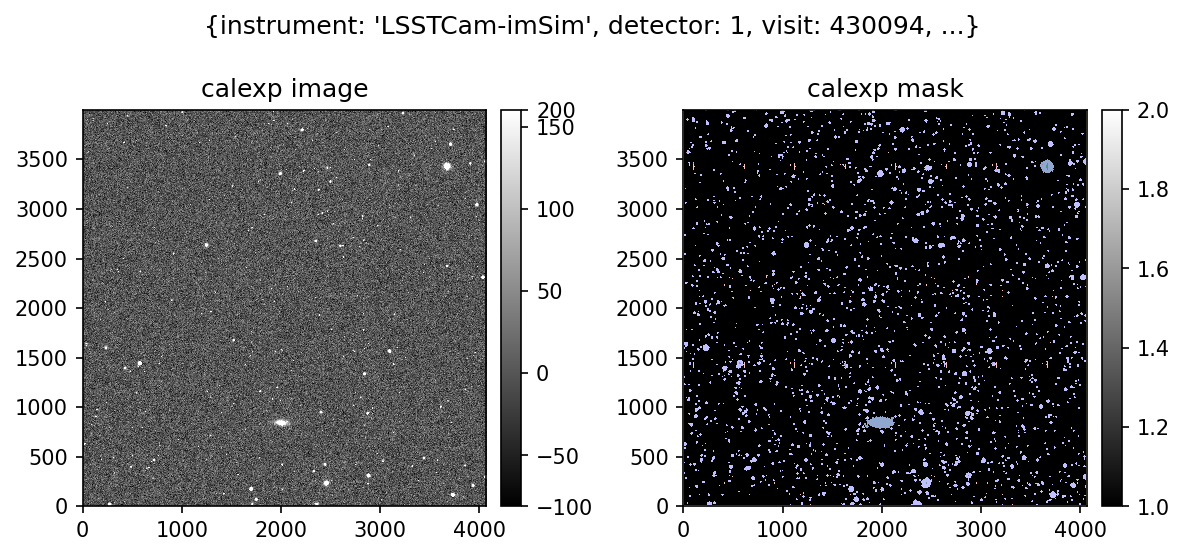

In [92]:
Q = 10

plot_calexp_g = calexp_g.clone()
plot_calexp_i = calexp_i.clone()
# plot_calexp.image.array = gaussian_filter(calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('linear', 'zscale')
#display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', min=1, max=2)
display1.mtv(plot_calexp_g.mask)
plt.title('calexp mask')

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

### Set up a synthetic source input catalogue
We now have a `calexp` image that we want to inject into. Next we need to set up a simple synthetic source catalogue.

In this notebook, we opt to inject 100 synthetic Sérsic sources into the detector.


WHAT ARE THE UNITS OF SCALE_RADIUS? I ASSUMED ARCSEC FROM THE DEMOS I'VE SEEN AND THE GALSIM DOCS, BUT IT GIVES ALL KINDS OF ERRORS ABOUT BEING TOO LARGE FOR THE MEMORY/IMAGE.

In [93]:
np.random.seed(0)

nsource = 100

x = np.random.uniform(0, calexp_i.getBBox().endX, nsource)
y = np.random.uniform(0, calexp_i.getBBox().endY, nsource)
ra, dec = calexp_i.wcs.pixelToSkyArray(x, y, degrees=True)
radii = np.random.uniform(1, 10, nsource)

si_cat = pd.DataFrame(dict(
    ra=ra,
    dec=dec,
    mag=np.random.uniform(15, 25, nsource),
    scale_radius=radii,
    truncation=10.0*radii,
    axis_ratio=np.random.uniform(0.1, 1, nsource),
    pa=np.random.uniform(0, 180, nsource),
    n=np.random.uniform(0.5, 4, nsource),
    source_type="Sersic",
))

display(si_cat[:5])

,ra,dec,mag,scale_radius,truncation,axis_ratio,pa,n,source_type
0,56.236804,-37.129397,24.065555,3.806163,38.061629,0.461134,55.868549,1.111304,Sersic
1,56.214422,-37.225682,22.740473,7.267091,72.670914,0.936362,67.146275,1.647958,Sersic
2,56.218517,-37.119534,18.331452,4.399767,43.997666,0.189653,94.494680,2.881220,Sersic
3,56.221345,-37.067580,15.811014,2.616433,26.164331,0.950771,135.107104,0.721227,Sersic
4,56.296520,-37.216374,19.072412,1.222109,12.221086,0.882540,60.031344,2.625373,Sersic


### Register the source injection collection
The input `si_cat` will be ingested into a RUN collection in the `repo`. Here we register this collection for subsequent use below.

To begin, we first instantiate a writable `butler`. Butlers are instantiated in read-only mode by default. By setting the argument `writeable` to `True`, a butler can also be made to be writeable.

> Warning: take care when working with a writeable butler, as data on-disk has the potential to be permanently removed or corrupted.

As a precaution, we attempt to remove our chosen RUN collection if it exists before continuing with processing. If we attempt to inject synthetic sources into a collection that already exists, the task will complain that the output data already exist on disk.

Finally, the source injection collection is registered in the `repo`.

In [94]:
writeable_butler =  Butler(config, writeable=True)

si_input_collection = "u/jcarlin/si_demo"

try:
    writeable_butler.removeRuns([si_input_collection])
except MissingCollectionError:
    print("Writing into a new RUN collection")
    pass
else:
    print("Prior RUN collection located and successfully removed")

_ = writeable_butler.registry.registerCollection(si_input_collection, type=CollectionType.RUN)

Prior RUN collection located and successfully removed


### Register the input catalogue dataset type

Here we define the `si_cat` dataset type, which lets the repo know about the dimensions and storage class for these synthetic source data.

Using this definition, the new dataset type is registered in the repo using `registerDatasetType`. This method returns True if the datasetType was inserted, and False if an identical existing DatsetType was found.

In [95]:
si_dataset_type =  DatasetType(
    "si_cat",
    dimensions=["skymap", "tract"],
    storageClass="DataFrame",
    universe=DimensionUniverse(),
)

writeable_butler.registry.registerDatasetType(si_dataset_type)

False

I have questions about the above output. Is this saying that I didn't accomplish adding the dataset type? If so, how do I ensure that the one that is registered already has the same dimensions and storageClass that I want?

### Ingest the input catalogue into the repo

Finally, we ingest the input catalogue into the repo.

In [96]:
dataset_ref = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat,
    band=dataId_i['band'],
    output_collection=si_input_collection,
    dataset_type_name='injection_catalog'
)

print(f'{dataset_ref = }')

dataset_ref = [DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'i', htm7: 147086}, id=0550b3ad-41c6-4c95-a4a7-d6409136e520, run='u/jcarlin/si_demo'), DatasetRef(DatasetType('injection_catalog', {band, htm7}, ArrowAstropy), {band: 'i', htm7: 147087}, id=af0a7e4b-6923-484e-8eb9-23920cdc354b, run='u/jcarlin/si_demo')]


### Instantiate the injection classes

At this stage, we have an input image and we have a fully ingested synthetic source input catalogue. We're now ready to inject synthetic sources into the image using the tools available in the `source_injection` repo.

First, we instantiate the `VisitInjectConfig` class. The `VisitInjectConfig` class is where configuration of the injection task occurs, allowing for modifications to be made to how the task operates.

Following this, we then instantiate the `VisitInjectTask`, using `inject_config` as the configuration argument.

In [97]:
inject_config = VisitInjectConfig()

display(inject_config)

inject_task = VisitInjectTask(config=inject_config)

lsst.source.injection.inject_visit.VisitInjectConfig(saveMetadata=True, saveLogOutput=True, process_all_data_ids=False, trim_padding=100, mask_plane_name='INJECTED', calib_flux_radius=12.0, fits_alignment='pixel', stamp_prefix='', col_ra='ra', col_dec='dec', col_mag='mag', col_source_type='source_type', col_stamp='stamp', col_draw_size='draw_size', col_trail_length='trail_length', connections={'injection_catalogs': '{injection_prefix}catalog', 'visit_summary': 'finalVisitSummary', 'input_exposure': 'calexp', 'output_exposure': '{injected_prefix}calexp', 'output_catalog': '{injected_prefix}calexp_catalog', 'injection_prefix': 'injection_', 'injected_prefix': 'injected_'}, external_psf=False, external_photo_calib=False, external_wcs=False)

### Retrieve the input table from the butler

In [98]:
butler = Butler(config)

tables = [butler.get(ref) for ref in dataset_ref]

In [99]:
tables

[<Table length=4>
 index         ra                dec         ...         n          source_type
 int64      float64            float64       ...      float64           str6   
 ----- ----------------- ------------------- ... ------------------ -----------
    26 56.38768693076933   -37.2526475422043 ...   3.17596691025198      Sersic
    75 56.40455187364989 -37.203313535340406 ...  2.786974063897729      Sersic
    79 56.39377372162129  -37.24872634954591 ... 1.9176246465393247      Sersic
    97 56.40805351280765  -37.19580655321026 ... 0.5669301410704142      Sersic,
 <Table length=96>
 index         ra                 dec         ...         n          source_type
 int64      float64             float64       ...      float64           str6   
 ----- ------------------ ------------------- ... ------------------ -----------
     0 56.236804139827235  -37.12939730924701 ... 1.1113043488825203      Sersic
     1 56.214422421642304  -37.22568219298851 ... 1.6479580031782788      Sers

### Run the source injection task

Finally, we execute the `run` method of the inject task.

As an input, the `run` method needs:

* the input injection catalogue
* the input exposure
* the PSF of the input exposure
* the WCS information
* the photometric calibration information

We get the PSF, WCS, and photo_calib inputs directly from the `calexp` they are associated with.

As an output, the inject task provides:

* the output exposure with sources injected
* the output source injection catalogue

The output source injection catalogue is identical to the input, excepting two additional columns (x and y) which denote the pixel coordinates of these sources. Note that this catalogue is NOT the science catalogue containing the full suite of LSST Science Pipelines outputs. To get that, this source injected image will need to be processed by additional standard Science Pipelines tasks (not discussed in this notebook).

> Note: here we use a clone of the input `calexp`. This is because the `calexp` is edited in-place, so inputting a clone allows us to continue using the original `calexp` later in this notebook.

In [100]:
inject_output = inject_task.run(
    injection_catalogs=tables,
    input_exposure=calexp_i.clone(),
    psf=calexp_i.getPsf(),
    photo_calib=calexp_i.getPhotoCalib(),
    wcs=calexp_i.getWcs(),
)
si_calexp = inject_output.output_exposure
si_cat_out = inject_output.output_catalog

display(si_cat_out[:5])

injection_id,injection_flag,injection_draw_size,index,ra,dec,mag,scale_radius,truncation,axis_ratio,pa,n,source_type
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str6
0,16,10000,26,56.38768693076933,-37.2526475422043,21.832813355476805,7.187394487490337,71.87394487490337,0.9904687995559883,95.49669862130072,3.17596691025198,Sersic
1,16,10000,75,56.40455187364989,-37.203313535340406,16.605388224852565,9.543869401741134,95.43869401741134,0.7756883756977168,54.00520550566733,2.786974063897729,Sersic
2,16,8390,79,56.39377372162129,-37.24872634954591,20.90984165323685,8.868591699624524,88.68591699624524,0.5066395144027837,163.41760698377868,1.9176246465393247,Sersic
3,0,442,97,56.40805351280765,-37.19580655321026,18.56706890402543,8.759723656795149,87.59723656795148,0.46154218184163875,84.71681085850372,0.5669301410704142,Sersic
4,0,380,0,56.236804139827235,-37.12939730924701,24.065554992211787,3.8061629379469233,38.06162937946923,0.4611335507232479,55.86854867636605,1.1113043488825203,Sersic


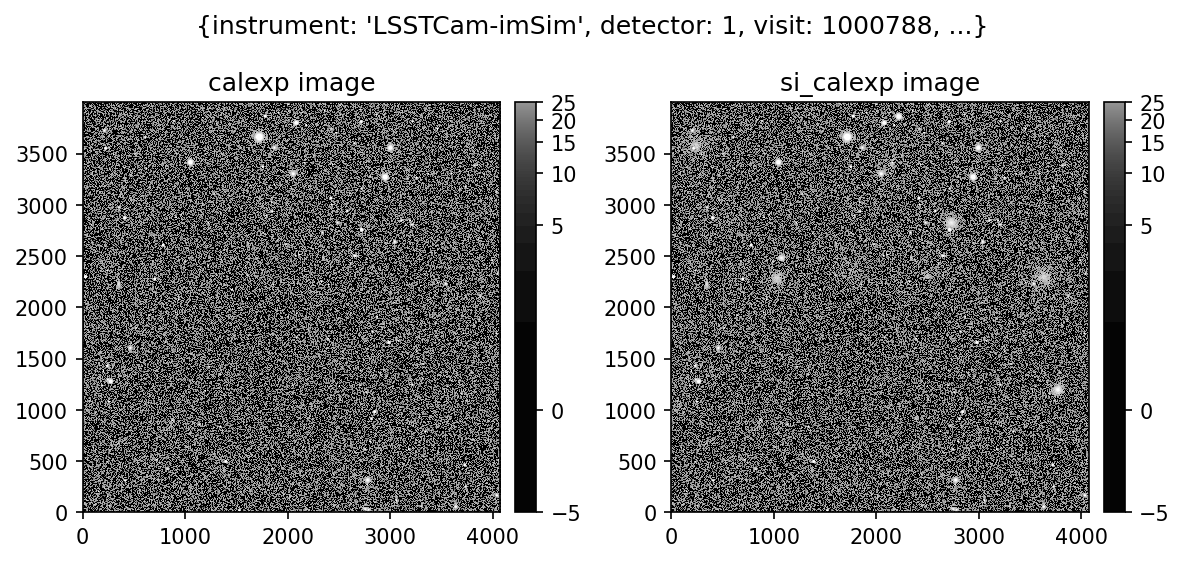

In [104]:
Q = 10

plot_si_calexp = si_calexp.clone()
# plot_si_calexp.image.array = gaussian_filter(si_calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(calexp_i.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp.image)
plt.title('si_calexp image')

plt.suptitle(str(dataId), y=0.8)
plt.tight_layout()
plt.show()

### Inject an artificial star cluster into the data and run measurement tasks

Install [Artpop](https://artpop.readthedocs.io/en/latest/index.html)

pip install --user artpop

In [ ]:
# use this random state for reproducibility
rand = np.random.RandomState(100)

# create old, metal-poor SSP source at 15 kpc

ssp = artpop.MISTPlummerSSP(
    log_age = 10.1,          # log of age in years
    feh = -2,             # metallicity [Fe/H]
    total_mass = 1.0e4,   # total mass in M_Sun
    distance = 15.0*u.kpc, # distance in kpc
    scale_radius = 10.0*u.pc, # scale radius in pc
    phot_system = 'LSST', # photometric system(s)
    imf = 'kroupa',       # default imf
    random_state = rand,   # random state for reproducibility
    xy_dim = 3999,
    pixel_scale = 0.2,
    mag_limit = 27.0,
    mag_limit_band = 'LSST_g',
)


In [ ]:
np.log10(12.5e9)

In [ ]:
ssp.mags

In [ ]:
wcs = calexp_g.getWcs()
bbox = calexp_g.getBBox()
boxcen = bbox.getCenter()
xcoords = ssp.x + boxcen.x - 2000
ycoords = ssp.y + boxcen.y - 2000
radec_coords = wcs.pixelToSkyArray(xcoords, ycoords, degrees=True)

In [ ]:
# Add extinction
# see https://github.com/rubin-dp0/delegate-contributions-dp02/blob/db7d06ba6203faa15732c5368ff6e52ea53c5796/MWhalo_density/Milky_Way_halo_density.ipynb#L64

# set the A_lamba/E(B-V) values for the six ugrizy LSST filters
band_a_ebv = np.array([4.812, 3.643, 2.699, 2.063, 1.578, 1.313])

coords = SkyCoord(radec_coords[0], radec_coords[1],
                  unit='deg', frame='icrs')

sfd = SFDQuery()
ebvvec = sfd(coords)

u_ext = ssp.mags['LSST_u'] + ebvvec*band_a_ebv[0]
g_ext = ssp.mags['LSST_g'] + ebvvec*band_a_ebv[1]
r_ext = ssp.mags['LSST_r'] + ebvvec*band_a_ebv[2]
i_ext = ssp.mags['LSST_i'] + ebvvec*band_a_ebv[3]
z_ext = ssp.mags['LSST_z'] + ebvvec*band_a_ebv[4]

In [ ]:
si_cat_stars_g = Table({'injection_id': np.arange(len(ssp.mags)),
                        'ra': radec_coords[0], 'dec': radec_coords[1],
                        'source_type': ['DeltaFunction']*len(ssp.mags),
                        'g_mag': g_ext, 'i_mag': i_ext,
                        'mag': g_ext,
                       })
#                      'g_mag': ssp.mags['LSST_g'], 'i_mag': ssp.mags['LSST_i'],
#                      'mag': ssp.mags['LSST_g'],

si_cat_stars_i = Table({'injection_id': np.arange(len(ssp.mags)),
                        'ra': radec_coords[0], 'dec': radec_coords[1],
                        'source_type': ['DeltaFunction']*len(ssp.mags),
                        'g_mag': g_ext, 'i_mag': i_ext,
                        'mag': i_ext,
                       })

In [ ]:
plt.plot(ssp.mags['LSST_g']-ssp.mags['LSST_i'], ssp.mags['LSST_g'], 'k.')
plt.plot(g_ext-i_ext, g_ext, 'r.')
plt.ylim(28, 15)
plt.xlim(-1, 3)
plt.show()

In [ ]:
writeable_butler =  Butler(config, writeable=True)

In [ ]:
si_input_collection = 'u/jcarlin/si_demo'

try:
    writeable_butler.removeRuns([si_input_collection])
except MissingCollectionError:
    print('Writing into a new RUN collection')
    pass
else:
    print('Prior RUN collection located and successfully removed')

In [ ]:
dataset_refs_g = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat_stars_g,
    band=dataId_g['band'],
    output_collection=si_input_collection,
    dataset_type_name='injection_catalog'
)

print(f'{dataset_refs_g = }')

dataset_refs_i = ingest_injection_catalog(
    writeable_butler=writeable_butler,
    table=si_cat_stars_i,
    band=dataId_i['band'],
    output_collection=si_input_collection,
    dataset_type_name='injection_catalog'
)

print(f'{dataset_refs_i = }')

In [ ]:
butler = Butler(config, collections=collections)

tables_g = [butler.get(ref) for ref in dataset_refs_g]
tables_i = [butler.get(ref) for ref in dataset_refs_i]

In [ ]:
inject_config = VisitInjectConfig()

display(inject_config)

inject_task = VisitInjectTask(config=inject_config)

In [ ]:
inject_output_g = inject_task.run(
    injection_catalogs=tables_g,
    input_exposure=calexp_g.clone(),
    psf=calexp_g.getPsf(),
    photo_calib=calexp_g.getPhotoCalib(),
    wcs=calexp_g.getWcs()
)

In [ ]:
inject_output_i = inject_task.run(
    injection_catalogs=tables_i,
    input_exposure=calexp_i.clone(),
    psf=calexp_i.getPsf(),
    photo_calib=calexp_i.getPhotoCalib(),
    wcs=calexp_i.getWcs()
)

In [ ]:
si_calexp_g = inject_output_g.output_exposure
si_cat_out_g = inject_output_g.output_catalog
si_calexp_i = inject_output_i.output_exposure
si_cat_out_i = inject_output_i.output_catalog

display(si_cat_out_g[:5])

In [ ]:
Q = 10

plot_si_calexp_g = si_calexp_g.clone()
plot_si_calexp_i = si_calexp_i.clone()
# plot_si_calexp.image.array = gaussian_filter(si_calexp.image.array, sigma=3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
#display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_calexp_g.image)
plt.title('calexp image')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("linear", "zscale")
# display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp_g.image)
plt.title('si_calexp image')

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale("linear", "zscale")
display0.mtv(plot_calexp_g.image)
plt.title('calexp image (zoom)')
plt.xlim(1000, 3000)
plt.ylim(1000, 3000)

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale("linear", "zscale")
#display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_si_calexp_g.image)
plt.title('si_calexp image (zoom)')
plt.xlim(1000, 3000)
plt.ylim(1000, 3000)

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

In [ ]:
plot_diff_calexp_g = calexp_g.clone()
plot_diff_calexp_g.image.array = si_calexp_g.image.array - calexp_g.image.array

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=150)

plt.sca(ax[0])
display0 = afwDisplay.Display(frame=fig)
display0.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display0.mtv(plot_diff_calexp_g.image)
plt.title('diff image (si_calexp - calexp)')

plt.sca(ax[1])
display1 = afwDisplay.Display(frame=fig)
display1.scale('asinh', min=-5/Q, max=25/Q, Q=Q)
display1.mtv(plot_diff_calexp_g.image)
plt.title('diff image with markers')
x, y = plot_diff_calexp_g.wcs.skyToPixelArray(si_cat_out_g['ra'], si_cat_out_g['dec'], degrees=True)
plt.scatter(x, y, marker='o', s=50, fc='none', ec='orange', lw=1.5)

plt.suptitle(str(dataId_g), y=0.8)
plt.tight_layout()
plt.show()

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [ ]:
def processFakes(calexp_inp, calexp_inp_new):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    print('schema = ')
    print(schema)
    
    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 5      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    #print('after config, schema = ')
    #print(schema)

    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
#    I'm not sure what this does or if it is necessary, but it seems to take a long time - Brian Morsony, 7/29/2022
    result = charImageTask.run(calexp_inp_new)

    # Get the PSF and some image properties
    psf = calexp_inp_new.getPsf()
    # sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp_new.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    sigma = 1./pixelScale/2.355
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp_new)
    
    sources = result.sources

    del result

    sources = sources.copy(True)
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp_new, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp_new)
    
    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp_new.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [ ]:
#t1 = time.time()

#sources_withfakes_u = processFakes(calexp_orig_u,calexp_new_u)
sources_withfakes_g = processFakes(plot_calexp_g, plot_si_calexp_g)
#sources_withfakes_r = processFakes(calexp_orig_r,calexp_new_r)
sources_withfakes_i = processFakes(plot_calexp_i, plot_si_calexp_i)

#t2 = time.time()
#print('dt', t2 - t1)

In [ ]:
sources_withfakes_g

In [ ]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=radec_coords[0]*u.deg, dec=radec_coords[1]*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
#sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
#sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

In [ ]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [ ]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

#idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
#idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

In [ ]:
okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = sources_withfakes_i[idx_i]['mag_psf']
mch_magerrs_i = sources_withfakes_i[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(g_ext[okmch_g], 1000.0 * (mch_mags_g[okmch_g] - g_ext[okmch_g]),
         'D', ms=3, color='mediumseagreen', label='g')
plt.plot(i_ext[okmch_i], 1000.0 * (mch_mags_i[okmch_i] - i_ext[okmch_i]),
         's', ms=3, color='indigo', label='i')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 24.8)
plt.ylim(-78, 78)
plt.minorticks_on()
plt.show()

In [ ]:
idx_gi, sep_gi, _ = sc_withfakes_g.match_to_catalog_sky(sc_withfakes_i)

In [ ]:
okmch_gi = sep_gi.arcsec < 1.0

In [ ]:
fig, ax = plt.subplots(figsize=(4, 6))

plt.plot(g_ext-i_ext, g_ext, 'ko', ms=3, alpha=0.5)
plt.plot(sources_withfakes_g[okmch_gi]['mag_psf']-sources_withfakes_i[idx_gi[okmch_gi]]['mag_psf'],
         sources_withfakes_g[okmch_gi]['mag_psf'],
         'o', ms=4, color='mediumseagreen', fillstyle='none')
plt.xlabel(r'$g-i$')
plt.ylabel(r'$g$')
plt.ylim(24.8, 14.8)
plt.xlim(-1, 3)
plt.minorticks_on()
plt.show()

In [ ]:
plt.hist(sep_g.arcsec, bins=100)
plt.show()

In [ ]:
plt.hist(g_ext-ssp.mags['LSST_g'], bins=20)
plt.show()

## Code scraps

In [ ]:
cen = wcs.pixelToSky(boxcen)
sc_cen = SkyCoord(ra=cen[0].asDegrees()*u.deg, dec=cen[1].asDegrees()*u.deg)
print(cen, sc_cen)

In [ ]:
c0 = cen[0]
c0.asDegrees()

In [ ]:
racen = []
deccen = []
sepcen = []
band = []

for ref in calexp_DatasetRefs:
    dataId = ref.dataId
    bbox_tmp = butler.get('calexp.bbox', dataId=dataId)
    wcs_tmp = butler.get('calexp.wcs', dataId=dataId)
    radec_cen = wcs_tmp.pixelToSky(bbox_tmp.getCenterX(), bbox_tmp.getCenterY())
    sc_cen_tmp = SkyCoord(ra=radec_cen[0].asDegrees()*u.deg, dec=radec_cen[1].asDegrees()*u.deg)
    racen.append(radec_cen[0].asDegrees())
    deccen.append(radec_cen[0].asDegrees())
    sepcen.append(sc_cen_tmp.separation(sc_cen))
    band.append(dataId['band'])
    #print(radec_cen)

In [ ]:
for i in range(len(racen)):
    print(band[i], racen[i], deccen[i], sepcen[i].arcmin)

In [ ]:
sepcen[0].arcmin

In [ ]:
np.random.seed(0)

nsource = 100

In [ ]:
x_lim = np.random.uniform(0, calexp.getBBox().endX, nsource)
y_lim = np.random.uniform(0, calexp.getBBox().endY, nsource)
ra_lim, dec_lim = calexp.wcs.pixelToSkyArray(x_lim, y_lim, degrees=True)

mag = np.random.uniform(15, 25, nsource)
# Sersic index
n = np.random.uniform(0.5, 4, nsource)
# major-to-minor axis ratio
q = np.random.uniform(0.5, 1, nsource)
# position angle of the object (in degrees)
beta = np.random.uniform(0, 180, nsource)

semimajor = np.random.uniform(1, 10, nsource)
half_light_radius = np.sqrt(semimajor**2 / q)

In [ ]:
si_cat = Table({
    'injection_id': np.arange(nsource),
    'ra': ra_lim, 'dec': dec_lim,
    'source_type': ['Sersic']*nsource,
    'mag': mag, 'n': n, 'q': q, 'beta': beta,
    'half_light_radius': half_light_radius})

display(si_cat[:5])

In [ ]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 56.39
deccen = -37.275

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
scatter_arcmin = 1.0

# "nfakes" is the number of fake stars to inject:
nfakes = 131

np.random.seed(715)   # make it reproducable, not random

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = racen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)
fake_decs = deccen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)

# Make artificial u magnitudes in a range:
min_umag = 19.0
max_umag = 23.0
mag_scatter = 0.3
fake_umags = np.linspace(min_umag, max_umag, nfakes)

# Now assign magnitudes in other bands using (~fixed) colors:
fake_gmags = fake_umags - (1.0 + mag_scatter * np.random.randn(nfakes))  # distrib centered on u-g=1.0
fake_rmags = fake_gmags - (0.4 + mag_scatter * np.random.randn(nfakes))  # distrib centered on g-r=0.4
fake_imags = fake_rmags - (0.2 + mag_scatter * np.random.randn(nfakes))  # distrib centered on r-i=0.2

# These are totally arbitrary colors, but should be kinda similar to BHB stars?

In [ ]:
si_cat_stars = Table({'injection_id': np.arange(nfakes),
                      'ra': fake_ras, 'dec': fake_decs,
                      'source_type': ['DeltaFunction']*nfakes,
                      'g_mag': fake_gmags, 'i_mag': fake_imags,
                      'mag': fake_gmags,
                     })

# Start by creating a dataframe with the fake dwarf data, setting all source_types to "star":

#input_catalogue = pd.DataFrame(dict(
#    ra=fake_ras,
#    dec=fake_decs,
#    g_mag=fake_gmags,
#    i_mag=fake_imags,
#    source_type="star",
#))

display(si_cat_stars[:5])